In [1]:
import cv2
import math
import numpy as np
import os
import matplotlib.pyplot as plt
import polarTransform
from PIL import Image, ImageDraw
from tqdm import tqdm
import glob

In [2]:
from localize_iris import localize_iris # Function to localize the iris (center, r_pupil, r_out_boundary)
from create_polar_im import create_polar_im # Function to create the polar image of the segmentation
from create_mask import create_mask # Function to create the mask
from show_img import show_img

In [3]:
# Get the paths of every file given a parent directory
def get_all_files(path):
    vect = []
    for path, subdirs, files in os.walk(path):
        for name in files:
            if (name == '.DS_Store') | (name=='Readme.txt'):
                pass
            else:
                vect.append(os.path.join(path, name))
        vect = sorted(vect)
    return vect

In [4]:
# Paths definition
path_dataset = '../dataset/'
path_dataset_images = path_dataset + 'images'
path_dataset_gt = path_dataset + 'groundtruth'
path_polar = '../new datasets/masks_DL_polar'
images = get_all_files(path_dataset_images)
polar_list = get_all_files(path_polar)
print(len(polar_list))

2240


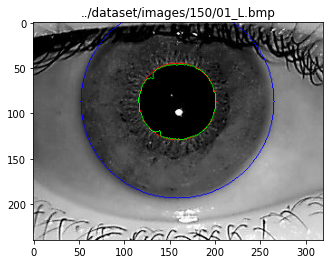

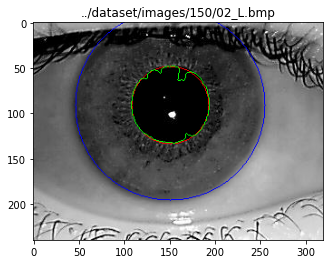

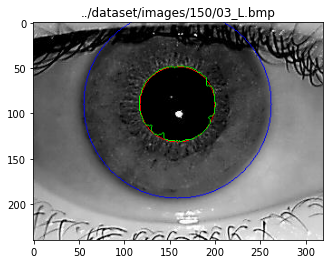

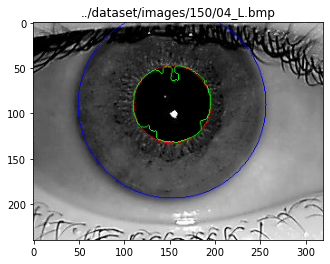

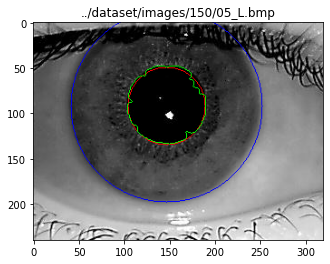

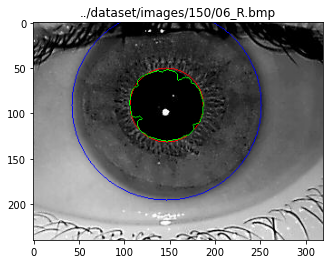

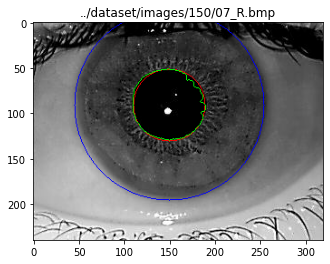

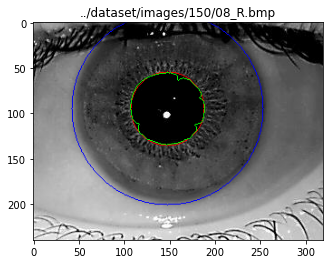

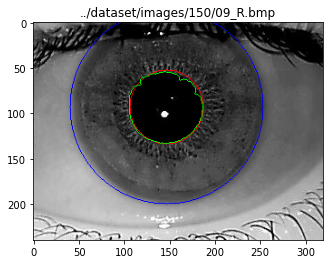

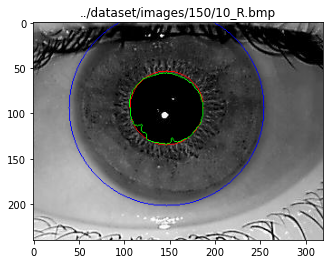

In [5]:
# To test the algorithm in one specific cases 
for i in (images[1490:1500]):
    cx, cy, r_pupil, r_out_bound, pupil_cont, img = localize_iris(i)
    show_img(cx, cy, r_pupil, r_out_bound, pupil_cont, img, i)

In [7]:
# Saving the images to a desired path
save_folder_masks = '../new datasets/masks_IP'
if not os.path.exists(save_folder_masks):
    os.mkdir(save_folder_masks)
    numb = ["{0:03}".format(i) for i in range(1,225)]
    for i in numb:
        os.mkdir(os.path.join(save_folder_masks,i))
            
for i in tqdm(images):
    create_mask(i,save_folder_masks)

100%|██████████| 2240/2240 [00:23<00:00, 96.11it/s]


In [9]:
def compute_dice(save_folder_masks, path_dataset_gt, thres):
    masks = get_all_files(save_folder_masks)
    gt = get_all_files(path_dataset_gt)
    dice = []
    thres = 0.6
    bad_cases = []
    for i,c in (enumerate(gt)):
        seg = cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE)/255
        im_gt = cv2.imread(c, cv2.IMREAD_GRAYSCALE)/255
        dice_val = np.sum([(seg==1.0)&(im_gt==1.0)])*2.0/(np.sum(seg)+np.sum(im_gt))
        dice.append(dice_val)
        if dice_val < thres:
            bad_cases.append(gt[i]) 

    print('These are the bad cases:')
    for i in bad_cases:
        print(i)
    print('\n')

    plt.plot(dice)
    plt.ylabel("DSC value")
    plt.xlabel("Image number")
    plt.title("DSC metric across the dataset")
    print(np.mean(dice))

These are the bad cases:
../dataset/groundtruth/OperatorA_035-B_06.tiff
../dataset/groundtruth/OperatorA_075-A_03.tiff
../dataset/groundtruth/OperatorA_087-A_02.tiff
../dataset/groundtruth/OperatorA_137-A_04.tiff


0.8635735756495697


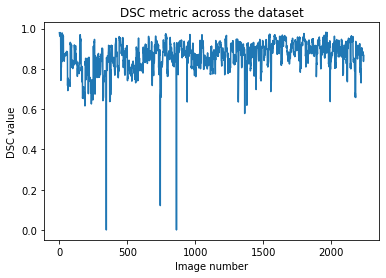

In [10]:
# Path where the images are saved
save_folder_masks = '../new datasets/masks_IP'
compute_dice(save_folder_masks, path_dataset_gt, 0.6)

In [10]:
# Creating the polar images
save_folder_polar = '../new datasets/masks_IP_polar'
if not os.path.exists(save_folder_polar):
    os.mkdir(save_folder_polar)
    numb = ["{0:03}".format(i) for i in range(1,225)]
    for i in numb:
        os.mkdir(os.path.join(save_folder_polar,i))

for i in tqdm(images):
    create_polar_im(i,save_folder_polar)

100%|██████████| 2240/2240 [00:35<00:00, 62.71it/s]


In [11]:
path_polar_im = '../new datasets/masks_IP_polar'
# Reshaping all the polar images to the same shape
y_coords = []
y_coords_resized = []
for i in get_all_files(path_polar_im):
    im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    y_coords.append(im.shape[0])
print([np.min(y_coords), np.mean(y_coords), np.max(y_coords)])

[52, 100.48972296693476, 236]


In [12]:
# Saving the resized polar images
save_folder_polar_mean = '../new datasets/masks_IP_polar_mean'

if not os.path.exists(save_folder_polar_mean):
    os.mkdir(save_folder_polar_mean)
    numb = ["{0:03}".format(i) for i in range(1,225)]
    for i in numb:
        os.mkdir(os.path.join(save_folder_polar_mean,i))

def np_to_PIL(im):
    im = (im-np.min(im))/(np.max(im)-np.min(im))*255.0
    im = Image.fromarray(np.uint8(im))
    return im

for i in tqdm(polar_list):
    im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    resized_mean = np_to_PIL(cv2.resize(im, (360,int(np.mean(y_coords))), interpolation=cv2.INTER_NEAREST_EXACT))
    save_path = os.path.basename(os.path.dirname(i)) + '/' + os.path.basename(i)[:-4]
    resized_mean.save(os.path.join(save_folder_polar_mean,save_path)+'.png')

100%|██████████| 2240/2240 [00:05<00:00, 447.04it/s]
